# Сегментирование клиентов онлайн-магазина подарков

## 1. Постановка задачи


Нам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import silhouette_score, accuracy_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from catboost import CatBoostClassifier
import optuna

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
PX_MODE = 'png'
# PX_MODE = None
RANDOM_STATE = 42

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [3]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.sample(15, random_state=421)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
99518,544774,22138,BAKING SET 9 PIECE RETROSPOT,3,2/23/2011 11:32,4.95,17711,United Kingdom
427768,573398,23265,SET OF 3 WOODEN TREE DECORATIONS,12,10/30/2011 15:28,1.25,17373,United Kingdom
45651,540275,20726,LUNCH BAG WOODLAND,40,1/6/2011 12:11,1.65,13680,United Kingdom
456440,575692,85199S,SMALL HANGING IVORY/RED WOOD BIRD,10,11/10/2011 16:27,0.42,12508,France
524455,580557,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,12,12/5/2011 10:19,1.25,14911,EIRE
366995,568829,23351,ROLL WRAP 50'S CHRISTMAS,12,9/29/2011 11:33,1.25,17633,United Kingdom
179079,552261,21790,VINTAGE SNAP CARDS,12,5/8/2011 11:34,0.85,16807,United Kingdom
74825,542529,DCGS0055,NaN,-1,1/28/2011 13:08,0.00,NaN,United Kingdom
412888,572301,23198,PANTRY MAGNETIC SHOPPING LIST,3,10/23/2011 14:41,1.45,16794,United Kingdom
276293,561037,23550,WRAP ALPHABET POSTER,25,7/24/2011 11:55,0.42,12472,Germany


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


О
пределим какие типы данных у наших признаков

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [5]:
numeric = []
categorical = []
for col in data.columns:
    if data[col].dtype == 'O':
        categorical.append(col)
    else:
        numeric.append(col)
        
print(f'Categorical and data features:\n{categorical}\nNumeric:\n{numeric}')

Categorical and data features:
['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Country']
Numeric:
['Quantity', 'UnitPrice']


Проверим данные на пропуски:

In [6]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это, заодно преобразуем тип признака к datetime



In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
categorical.remove('InvoiceDate')
data['InvoiceDate'].describe()

count                           541909
mean     2011-07-04 13:34:57.156386048
min                2010-12-01 08:26:00
25%                2011-03-28 11:34:00
50%                2011-07-19 17:17:00
75%                2011-10-19 11:27:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

Посмотрим на основные описательные статистики, чтобы уже на этом этапе наметить план работ по обработке признаков

In [8]:
data[numeric].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [9]:
# Товары с минимальной неотрицательной стоимостью
data.loc[data.UnitPrice >= 0, 'UnitPrice'].nsmallest(5)

622     0.0
1970    0.0
1971    0.0
1972    0.0
1987    0.0
Name: UnitPrice, dtype: float64

In [10]:
data.loc[data.UnitPrice == 0, 'UnitPrice'].count()

2515

Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции).

Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром» — они тоже нуждаются в дополнительной проверке.

In [11]:
data[categorical].describe()

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


In [12]:
data.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

видим специальный код 'Unspecified', обозначающий неопределенную страну

## 3. Предобработка и очистка данных

Мы уже узнали, что пропуски есть в двух признаках:
- Description      1454
- CustomerID     135080

Пропуски в столбцах с идентификатором клиента или описанием товара свидетельствуют о некорректных/незавершённых транзакциях и такие объекты не несут для нас полезной информации и являются непригодными для использования - удалим такие объекты.

In [13]:
data.dropna(subset=['Description', 'CustomerID'], axis=0, how='any', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


#### Следом за пропусками проверим наличие дубликатов.


In [14]:
data.duplicated().sum()

5225

Удалим их

In [15]:
data.drop_duplicates(inplace=True)
print(f'Data shape: {data.shape}')

Data shape: (401604, 8)


Ранее мы заметили, что в столбце с количеством товара **есть отрицательные значения**. Давайте разберемся, откуда они взялись. Выведем 10 строк таблицы, в которой столбец Quantity меньше 0.

In [16]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.sample(10, random_state=421)

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
91735,C544117,POST,POSTAGE,-1,2011-02-16 11:48:00,18.00,12727,France
1976,C536548,22892,SET OF SALT AND PEPPER TOADSTOOLS,-7,2010-12-01 14:33:00,1.25,12472,Germany
481895,C577375,23118,PARISIENNE JEWELLERY DRAWER,-2,2011-11-18 16:21:00,7.50,14441,United Kingdom
355049,C567902,22382,LUNCH BAG SPACEBOY DESIGN,-1,2011-09-22 16:29:00,1.65,15555,United Kingdom
394030,C570867,22649,STRAWBERRY FAIRY CAKE TEAPOT,-8,2011-10-12 16:17:00,4.95,12607,USA
74458,C542426,21481,FAWN BLUE HOT WATER BOTTLE,-36,2011-01-28 09:32:00,2.55,14146,United Kingdom
313424,C564493,84949,SILVER HANGING T-LIGHT HOLDER,-6,2011-08-25 14:19:00,1.65,13089,United Kingdom
438868,C574337,23080,RED METAL BOX TOP SECRET,-4,2011-11-04 10:03:00,8.25,16979,United Kingdom
240021,C558082,22430,ENAMEL WATERING CAN CREAM,-8,2011-06-26 11:43:00,4.95,16239,United Kingdom
328768,C565804,22846,BREAD BIN DINER STYLE RED,-1,2011-09-07 10:50:00,16.95,17491,United Kingdom


При просмотре таблицы можно заметить следующее:

- Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.
- Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
- Код товара может содержать различные специальные символы: например, символы "A", "B", "D".
- Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

> При анализе таблицы можно было заметить, что отрицательное количество товаров может не сопровождаться признаком возврата (символ "C" перед номером заказа отсутствует). Таких транзакций 1336 штук, и для всех них не указан идентификатор пользователя (CustomerID), например строка с индексом 74825. Мы удалили эти транзакции, когда удаляли строки таблицы, в которых пропущен идентификатор пользователя.

**Давайте проверим**, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [17]:
negative_quantity[~negative_quantity.InvoiceNo.str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Все транзакции с отрицательным количеством товара являются возвратами.

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [18]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Description'].count()
nb_products_per_basket = temp.rename(columns = {'Description':'Number of products'})
nb_products_per_basket.head(10)

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Посмотрим, сколько процентов заказов в таблице являются возвратами? 

In [19]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x.startswith('C') else 0)
nb_products_per_basket['order_canceled'].value_counts(normalize = True)*100

order_canceled
0    83.533123
1    16.466877
Name: proportion, dtype: float64

Давайте поближе взглянем на отмененные заказы:


In [20]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [21]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Видим, что столбцы StockCode, UnitPrice, CustomerID и Quantity, совпадают для двух транзакций. 

#### Выдвигаем гипотезу:
 для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.


In [22]:
temp = data.sort_values(by='InvoiceDate').drop_duplicates(subset=['StockCode', 'UnitPrice', 'CustomerID', 'Quantity'])
temp[temp.InvoiceNo.str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315,United Kingdom


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [23]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

#### Выдвигаем новую гипотезу:
 для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.


In [24]:
temp = data.sort_values(by='InvoiceDate').drop_duplicates(subset=['StockCode', 'UnitPrice', 'CustomerID', 'Quantity'])
temp[(temp.InvoiceNo.str.startswith('C')) & (temp.StockCode!='D')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315,United Kingdom


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [25]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Создадим функцию get_quantity_canceled . Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец .


In [26]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [27]:
data['QuantityCanceled'] = quantity_canceled

Подсчитаем суммарное количество отмененных товаров в столбце QuantityCanceled. 

In [28]:
quantity_canceled.sum()

245266.0

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара. 

In [29]:
data.drop(negative_quantity.index, inplace=True)
data.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


С помощью регулярных выражений найдем такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

In [30]:
indexes = data[data.StockCode.str.contains('^[a-zA-Z]+', regex=True)].index
data[data.StockCode.str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].value_counts()

StockCode
POST            1099
M                285
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

In [31]:
data.drop(indexes, inplace=True)

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 
Посмотрим в скольких транзакциях цена за единицу товара равна 0?


In [32]:
indexes = data[data.UnitPrice == 0].index
indexes.shape

(33,)

Таких транзакций оказалось менее 0.01 %, поэтому от них можно просто избавиться. Удалим такие транзакции из таблицы. 

In [33]:
data.drop(indexes, inplace=True)
data.shape

(391150, 9)

Этап очистки данных завершён. Сохраним полученный результат в отдельный файл.

In [34]:
data.to_csv('data/cleaned_data.csv', index=False)

In [35]:
data = pd.read_csv('data/cleaned_data.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [36]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты.

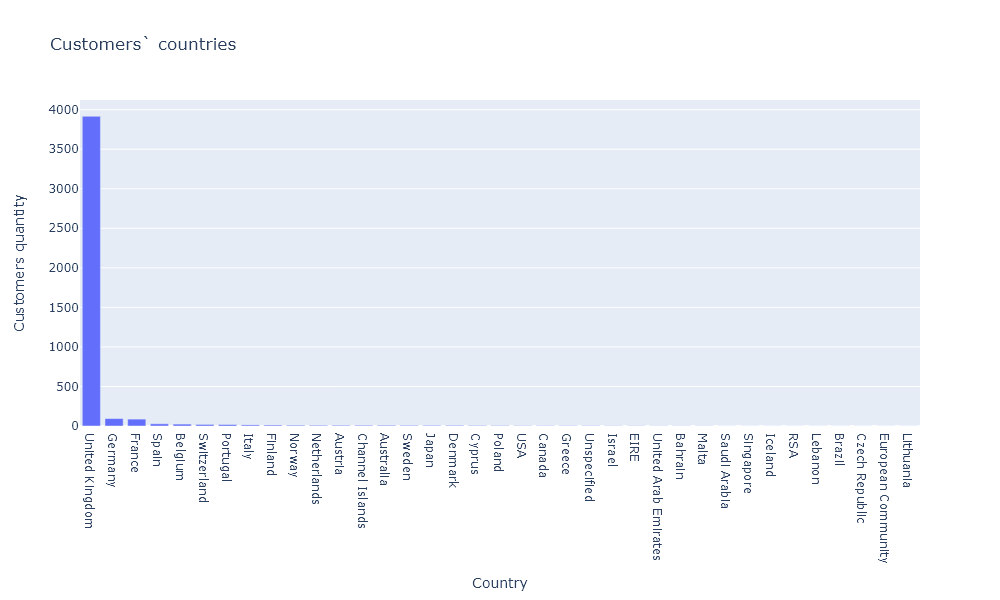

In [37]:
pivot = data.groupby(by='CustomerID')['Country'].first().value_counts()
pivot
fig = px.bar(pivot,
             labels={'value': 'Customers quantity', 'index': 'Country'},
             width=1000,
             height=600,
             title='Customers` countries',
             )
fig.update_layout(showlegend=False)
fig.show(PX_MODE);


Мы посмотрели на распределение клиентов в разрезе стран. А теперь посмотрим топ-3 стран по количеству поступающих заказов.

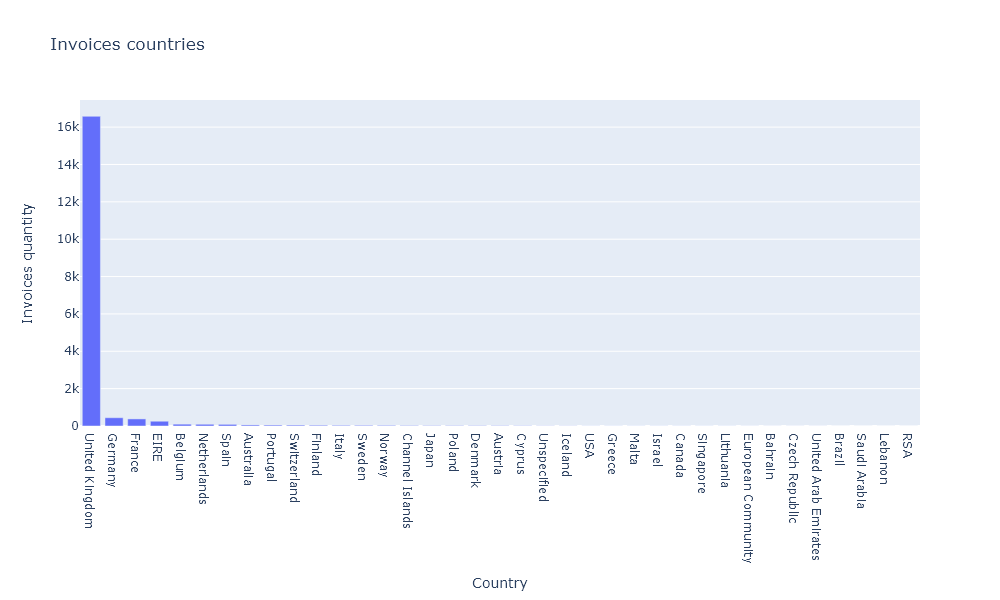

In [38]:
pivot = data.groupby(by='InvoiceNo')['Country'].first().value_counts()
pivot
fig = px.bar(pivot,
             labels={'value': 'Invoices quantity', 'index': 'Country'},
             width=1000,
             height=600,
             title='Invoices countries',
             )
fig.update_layout(showlegend=False)
fig.show(PX_MODE);

Давайте добавим в датасет общую стоимость заказа, назовём её TotalPrice.

In [39]:
data['Total_Price'] = data['UnitPrice'] * (data['Quantity']-data['QuantityCanceled'])
data['Total_Price'].describe()

count    391150.000000
mean         21.126404
std          67.823746
min         -81.000000
25%           4.680000
50%          11.700000
75%          19.500000
max        7144.720000
Name: Total_Price, dtype: float64

Построим визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:

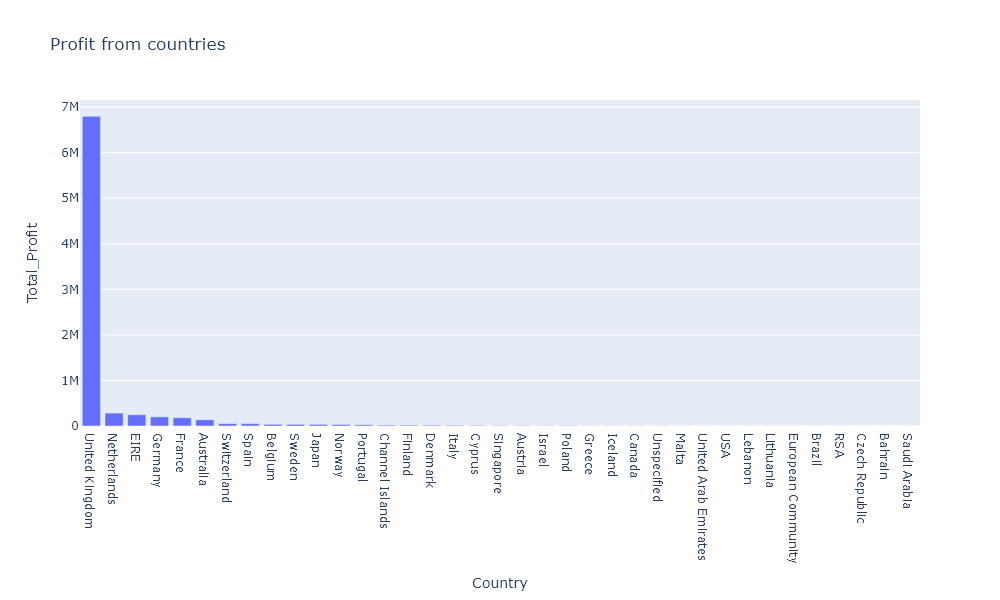

In [40]:
pivot = data.groupby(by='Country')['Total_Price'].sum().sort_values(ascending=False)
pivot
fig = px.bar(pivot,
             labels={'value': 'Total_Profit', 'index': 'Country'},
             width=1000,
             height=600,
             title='Profit from countries',
             )
fig.update_layout(showlegend=False)
fig.show(PX_MODE);

Теперь займёмся временными характеристиками.


Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. 

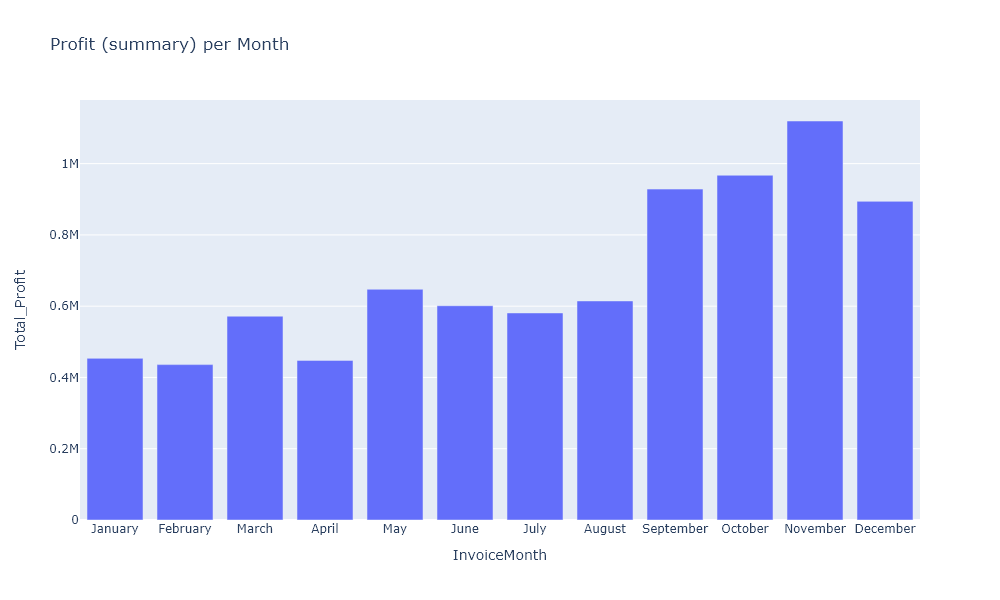

In [41]:
data['InvoiceMonth'] = data.InvoiceDate.dt.month
data['InvoiceDoW'] = data.InvoiceDate.dt.dayofweek
data['InvoiceHour'] = data.InvoiceDate.dt.hour
dict_month = {i+1:ind for i, ind in enumerate(pd.date_range('2016', freq='M', periods=12).month_name())}
pivot = data.groupby(by='InvoiceMonth')['Total_Price'].sum().rename(dict_month)
pivot
fig = px.bar(pivot,
             labels={'value': 'Total_Profit'},
             width=1000,
             height=600,
             title='Profit (summary) per Month',
             )
fig.update_layout(showlegend=False)
fig.show(PX_MODE);

Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии празников: католическое Рождество и Новый год.

Построим визуализацию количества заказов для каждого дня недели. 

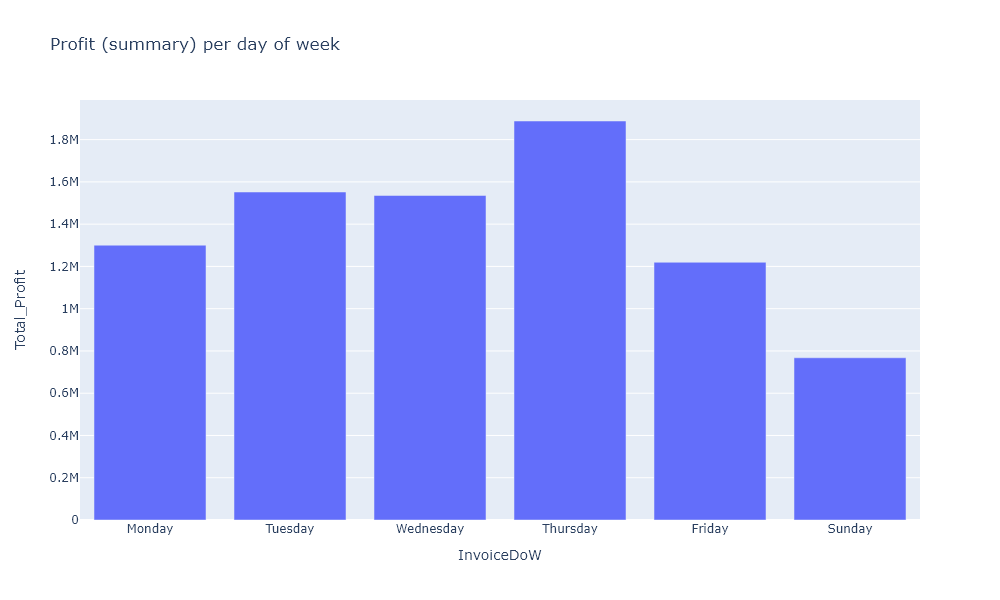

In [42]:
dict_dow = {i:ind for i, ind in enumerate(pd.date_range('2018', freq='D', periods=7).day_name())}
pivot = data.groupby(by='InvoiceDoW')['Total_Price'].sum().sort_index().rename(dict_dow)
pivot
fig = px.bar(pivot,
             labels={'value': 'Total_Profit'},
             width=1000,
             height=600,
             title='Profit (summary) per day of week',
             )
fig.update_layout(showlegend=False)
fig.show(PX_MODE);

Cогласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.


Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).


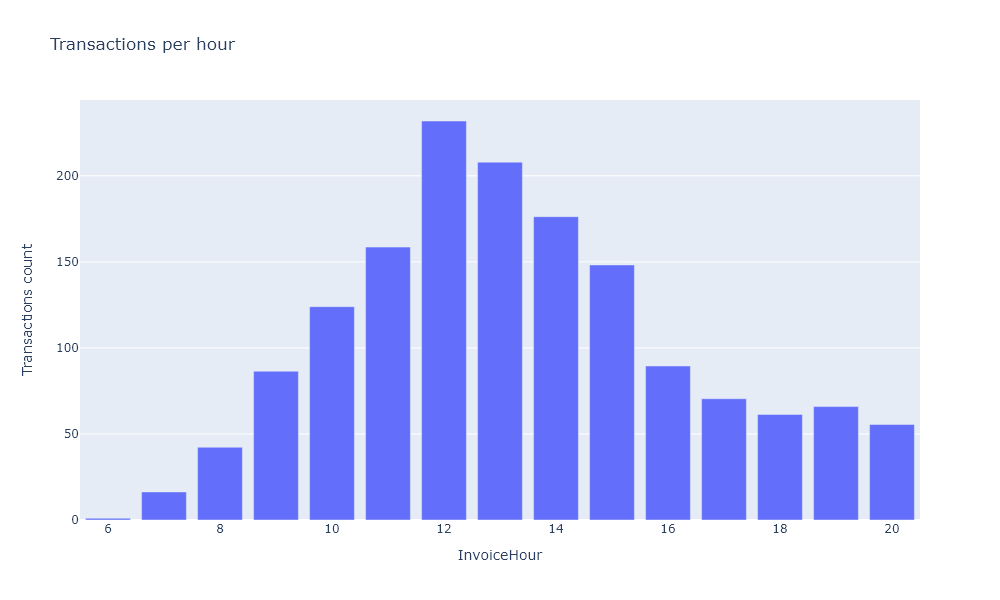

In [43]:
data['InvoiceDate_'] = data.InvoiceDate.dt.date
pivot = data.groupby(by=['InvoiceDate_', 'InvoiceHour'], as_index=False)['InvoiceNo'].count().groupby('InvoiceHour')['InvoiceNo'].mean()
pivot
fig = px.bar(pivot,
             labels={'value': 'Transactions count'},
             width=1000,
             height=600,
             title='Transactions per hour',
             )
fig.update_layout(showlegend=False)
fig.show(PX_MODE);


* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Итак, приступим к созданию RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).


In [44]:
rfm_table = data.groupby(by='CustomerID').agg({'InvoiceDate':'max', 'InvoiceNo':'nunique', 'Total_Price': 'sum'}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total_Price': 'Monetary'})
rfm_table['Recency'] = (pd.to_datetime('2011-12-10 00:00:00') - rfm_table['Recency']).dt.days
rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


In [45]:
print(f'{rfm_table.loc[rfm_table["Recency"] > 200, "Recency"].count()} клиентов совершили покупку более 200 дней назад')
print(f"{rfm_table['Frequency'].mean():.0f} заказов в среднем делает клиент (за представленный годовой период)")
print(f"{rfm_table.loc[12360, 'Monetary']:.0f} фунтов общая сумма денег, которую потратил клиент с идентификатором 12360")

743 клиентов совершили покупку более 200 дней назад
4 заказов в среднем делает клиент (за представленный годовой период)
2302 фунтов общая сумма денег, которую потратил клиент с идентификатором 12360


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

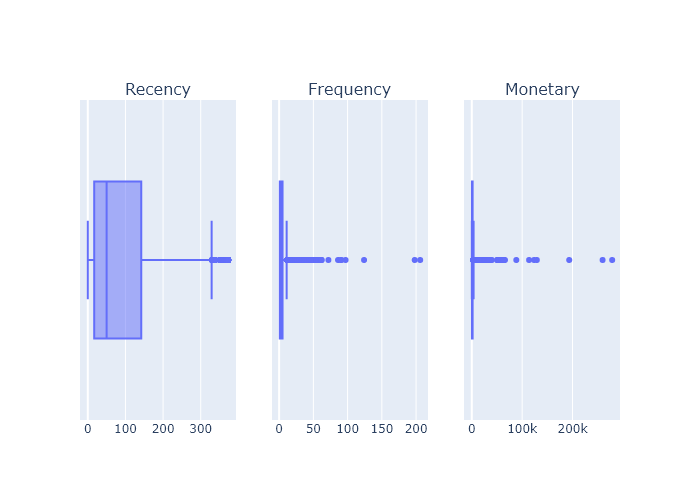

In [46]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    column_widths=(300,300,300),
    row_heights=[500],
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show(PX_MODE)

Видим, что есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 150 тысяч фунтов стерлингов.

Так как выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому нужно от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 




In [109]:
rfm_table_cleaned = rfm_table.copy()
mask = rfm_table_cleaned['Frequency'] > rfm_table_cleaned['Frequency'].quantile(0.95)
mask2 = rfm_table_cleaned['Monetary'] > rfm_table_cleaned['Monetary'].quantile(0.95)
rfm_table_cleaned = rfm_table_cleaned[(~mask) & (~mask2)]
rfm_table_cleaned.shape    

(4044, 3)

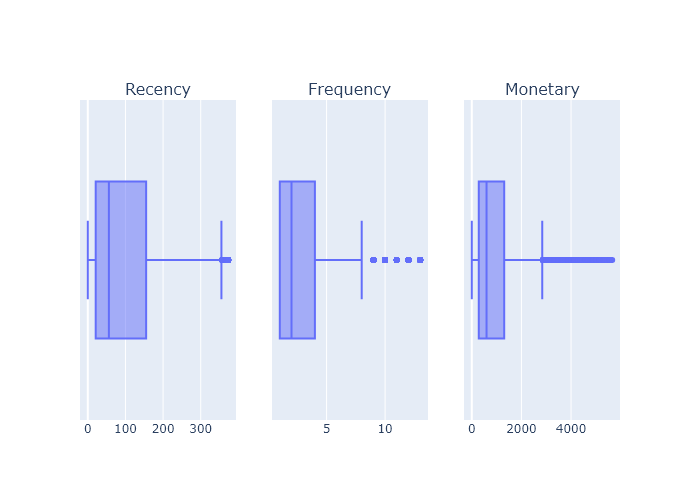

In [111]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    column_widths=(300,300,300),
    row_heights=[500],
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show(PX_MODE)

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


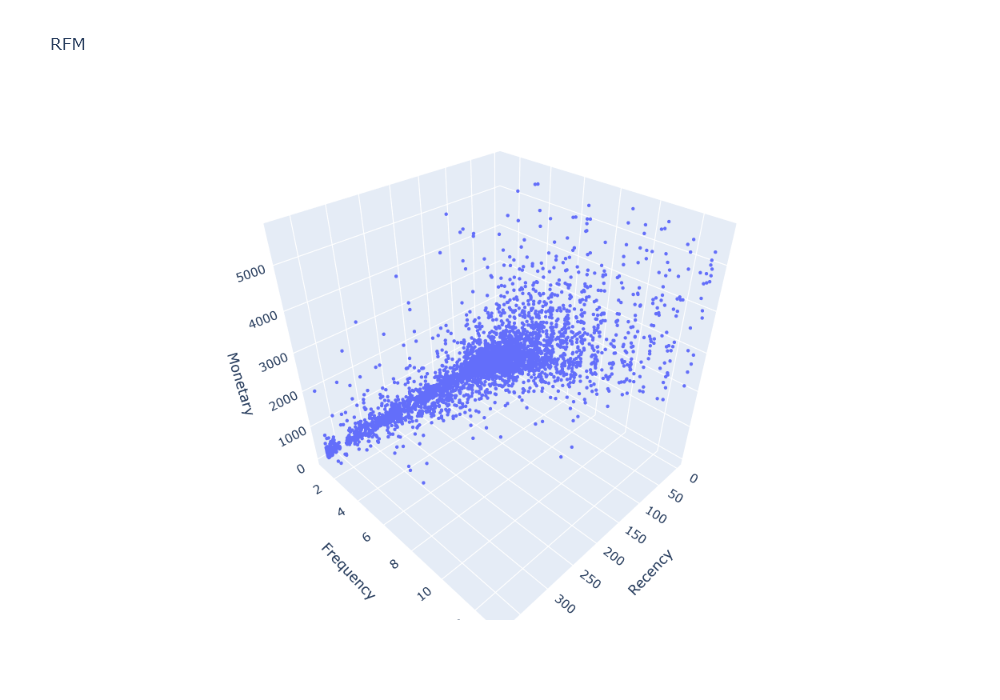

In [49]:
# визуализируем данные, передав значения x, y, z,
fig = px.scatter_3d(
    x=rfm_table_cleaned['Recency'].to_list(), 
    y=rfm_table_cleaned['Frequency'].to_list(),
    z=rfm_table_cleaned['Monetary'].to_list(),
    width=1000,
    height=700,
    title='RFM',
    labels={'x':'Recency', 'y': 'Frequency', 'z': 'Monetary'},
)
fig.update_traces(marker_size = 2)
fig.show(PX_MODE)


Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.



### Начнём с метода главных компонент (PCA).

Для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Обернём эти шаги по предобработке данных в pipeline.


In [50]:
pipeline = Pipeline([('scaler', StandardScaler()),('PCA', PCA(n_components=2))])
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
print(f"Доля объясняемой признаками дисперсии: {pipeline['PCA'].explained_variance_ratio_}")
rfm_table_processed = pd.DataFrame(data=rfm_table_processed, columns=['axis-1', 'axis-2'])

Доля объясняемой признаками дисперсии: [0.67747053 0.24012744]


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

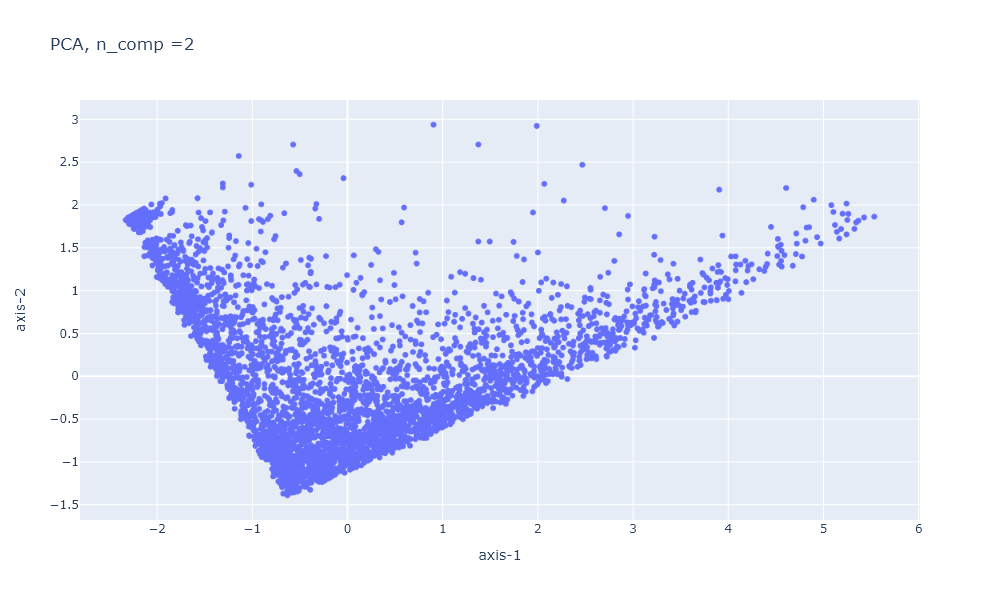

In [51]:
fig = px.scatter(
    rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    width=1000,
    height=600,
    labels={'color': 'Clusters'},
    title='PCA, n_comp =2'
)
fig.update_layout(showlegend=False)

fig.show(PX_MODE);

Попробуем разделить это пространство главных компонент на сегменты. 

Судя по форме пространства, мы можем с уверенностью сказать, что нам не подойдут алгоритмы, основанные на плотности, такие как DBSCAN, так как точки расположены очень близко друг к другу и большая часть точек будет определена в единый кластер, что не имеет смысла.

### Сначала воспользуемся методом k-means. 

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта.

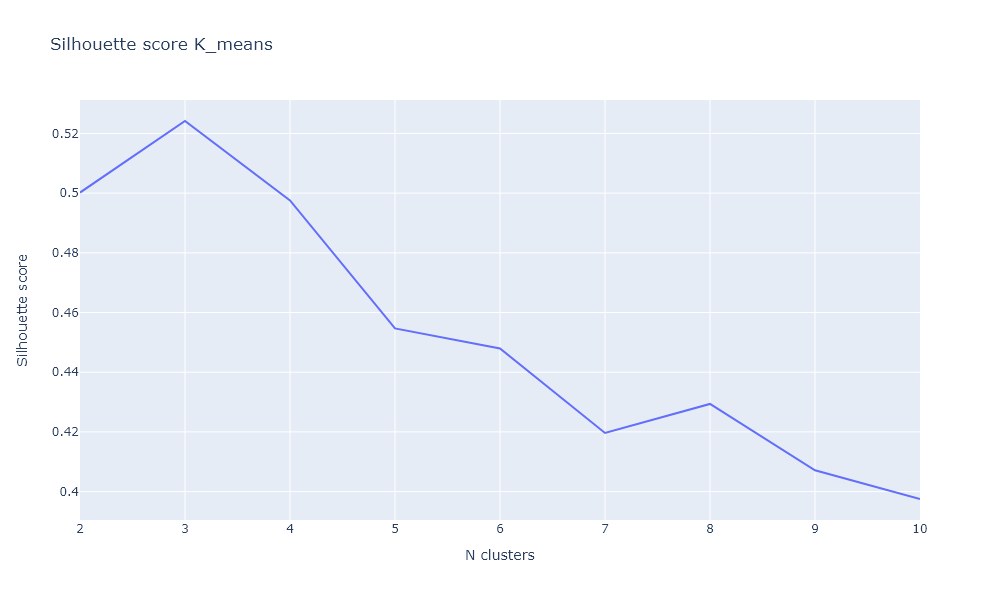

In [52]:
def get_silhouet(X, model):
    labels = model.fit_predict(X)
    
    return silhouette_score(X, labels)

n_clust_range = range(2,11)
silh_scores_kmeans = []
for n in n_clust_range:
    model = KMeans(n_clusters=n, random_state=RANDOM_STATE)
    silh_scores_kmeans.append(get_silhouet(rfm_table_processed, model))

fig = px.line(x=n_clust_range, y=silh_scores_kmeans,
              labels={'y':'Silhouette score', 'x': 'N clusters'},
              title='Silhouette score K_means',
              width=1000,
              height=600,
              )
fig.show(PX_MODE)


По методу коэффициента силуэта, оптимальное количество кластеров - 3

### Теперь возьмём EM-алгоритм.

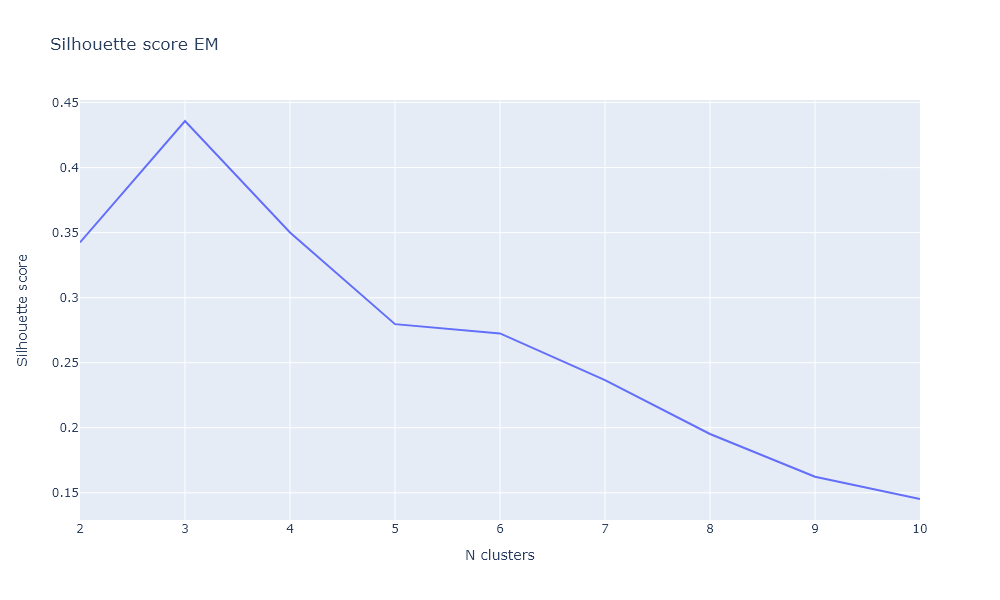

In [53]:
silh_scores_em = []
for n in n_clust_range:
    model = GaussianMixture(n_components=n, random_state=RANDOM_STATE)
    silh_scores_em.append(get_silhouet(rfm_table_processed, model))

fig = px.line(x=n_clust_range, y=silh_scores_em,
              labels={'y':'Silhouette score', 'x': 'N clusters'},
              title='Silhouette score EM',
              width=1000,
              height=600,
              )
fig.show(PX_MODE)

Для GaussianMixture также оптимальным является значение кластеров - 3, однако получаем чуть хуже оценку silhouette score чем у Kmeans.

Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных и посмотрим на результаты кластеризации.

In [54]:
model = KMeans(n_clusters=3, random_state=RANDOM_STATE)
labels = model.fit_predict(rfm_table_processed)
np.unique(labels, return_counts=True) 

(array([0, 1, 2]), array([2267,  776, 1001], dtype=int64))

Визуализируем результаты кластеризации:

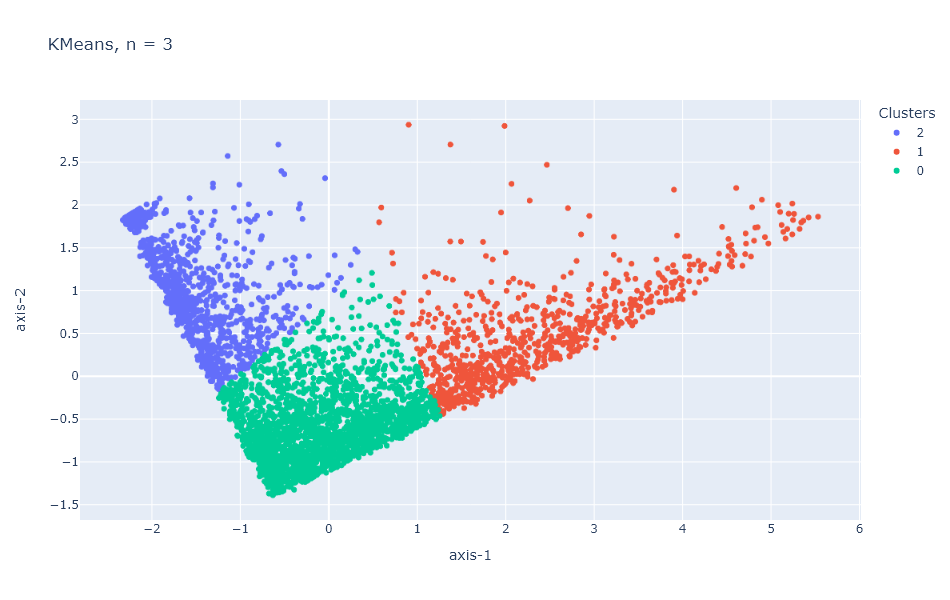

In [55]:
fig = px.scatter(
    rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    width=950,
    height=600,
    color=[str(label) for label in labels],
    labels={'color': 'Clusters'},
    title='KMeans, n = 3'
)

fig.update_layout(showlegend=True)
fig.show(PX_MODE);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [56]:
rfm_table_cleaned['label'] = labels

rfm_grouped = rfm_table_cleaned.groupby(by='label').mean()
rfm_grouped

,Recency,Frequency,Monetary
label,,,
0,51.127481,2.329069,660.168677
1,31.943299,7.068299,2657.746997
2,253.283716,1.405594,386.598472


In [57]:
rfm_table_cleaned.groupby(by='label').describe()

Recency                                                            \
        count        mean        std    min    25%    50%    75%    max   
label                                                                     
0      2267.0   51.127481  39.787233    0.0   19.0   42.0   74.0  189.0   
1       776.0   31.943299  38.161212    0.0    8.0   18.0   42.0  306.0   
2      1001.0  253.283716  64.594964  141.0  197.0  248.0  304.0  373.0   

      Frequency            ...            Monetary                            \
          count      mean  ...  75%   max    count         mean          std   
label                      ...                                                 
0        2267.0  2.329069  ...  3.0   7.0   2267.0   660.168677   467.480381   
1         776.0  7.068299  ...  9.0  13.0    776.0  2657.746997  1041.360411   
2        1001.0  1.405594  ...  2.0   6.0   1001.0   386.598472   369.102751   

                                                        
          min        25%       50%        75%      max  
label                                                   
0        0.00   297.6400   557.620   928.9800  2601.55  
1      515.73  1860.8475  2490.945  3299.8825  5657.85  
2        0.00   157.9000   292.470   460.5900  3202.92  

[3 rows x 24 columns]

Видим следущий результат кластеризации в контексте RFM анализа : 1 кластер это группа лояльных клиентов, 0 - 'спящие', а 2 - перспективные.

### Полярная диаграмма

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [58]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
        title='RFM cluster polar'
    )
    # Отображаем фигуру
    fig.show(PX_MODE)
    

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 


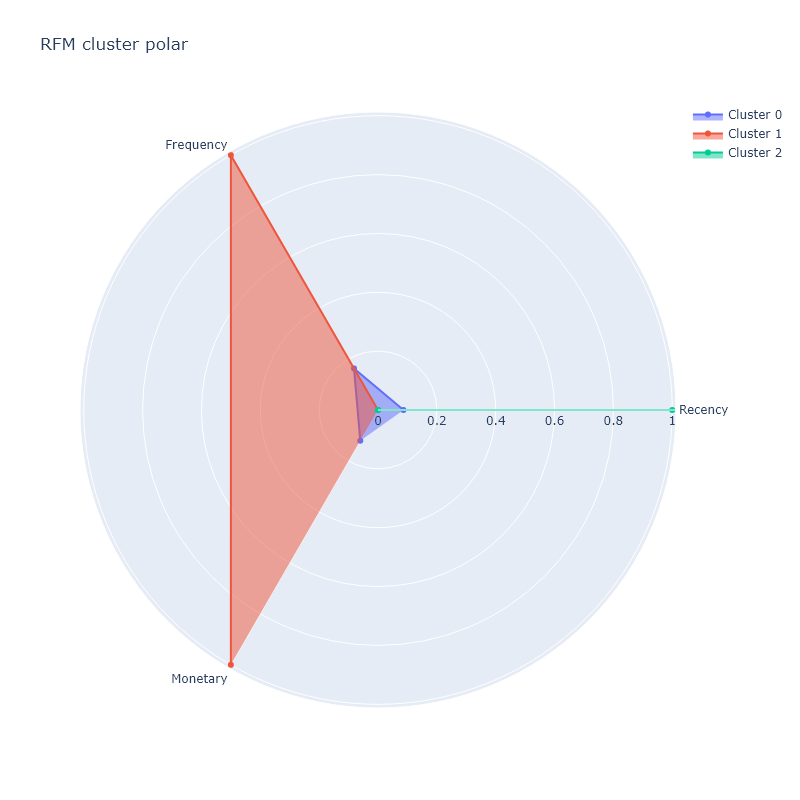

In [59]:
plot_cluster_profile(rfm_grouped, 3)

* 1ый кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* 2ой кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* 0ой кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### t-SNE
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Найдем чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE.

In [60]:
pipeline = Pipeline([('scaler', StandardScaler()),('TSNE', TSNE(n_components=2, perplexity=50, random_state=100))])
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned.drop('label', axis=1))
print(f"значение дивергенции Кульбака — Лейблера: {pipeline['TSNE'].kl_divergence_:.2f}")
rfm_table_processed = pd.DataFrame(data=rfm_table_processed, columns=['axis-1', 'axis-2'])

значение дивергенции Кульбака — Лейблера: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


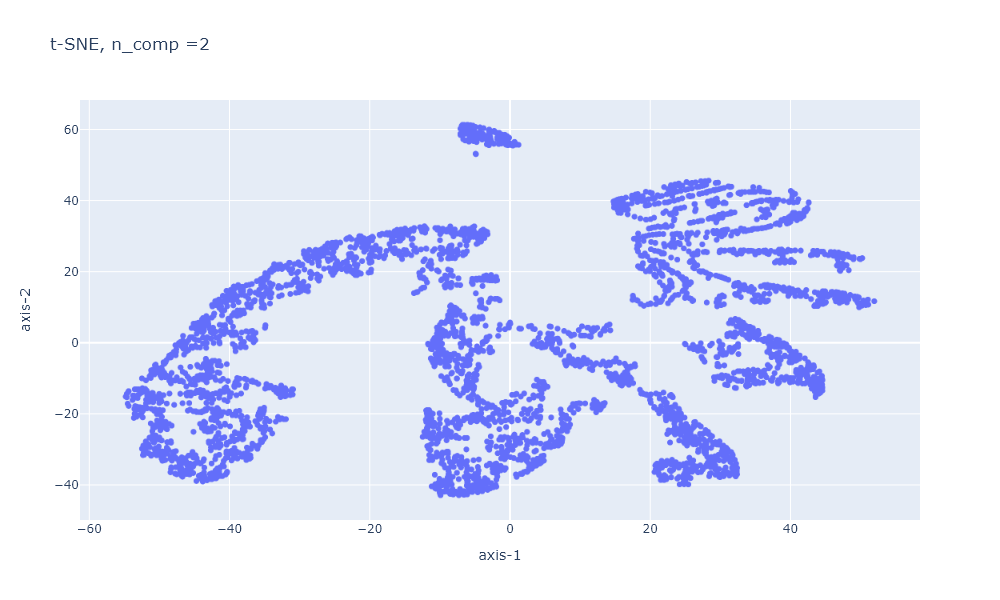

In [61]:
fig = px.scatter(
    rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    width=1000,
    height=600,
    labels={'color': 'Clusters'},
    title='t-SNE, n_comp =2'
)
fig.update_layout(showlegend=False)

fig.show(PX_MODE);

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### k-means
Попробуем воспользоваться методом k-means. 
Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 


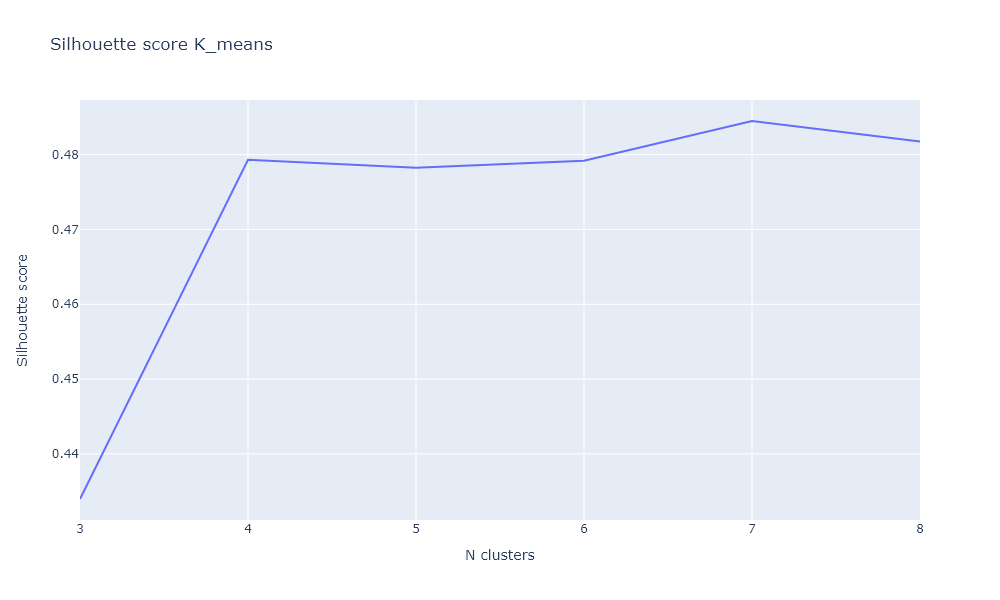

In [62]:
n_clust_range = range(3,9)
silh_scores_kmeans = []
for n in n_clust_range:
    model = KMeans(n_clusters=n, random_state=RANDOM_STATE)
    silh_scores_kmeans.append(get_silhouet(rfm_table_processed, model))

fig = px.line(x=n_clust_range, y=silh_scores_kmeans,
              labels={'y':'Silhouette score', 'x': 'N clusters'},
              title='Silhouette score K_means',
              width=1000,
              height=600,
              )
fig.show(PX_MODE)

### EM-алгоритм
Попробуем воспользоваться EM-алгоритом. 

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта.

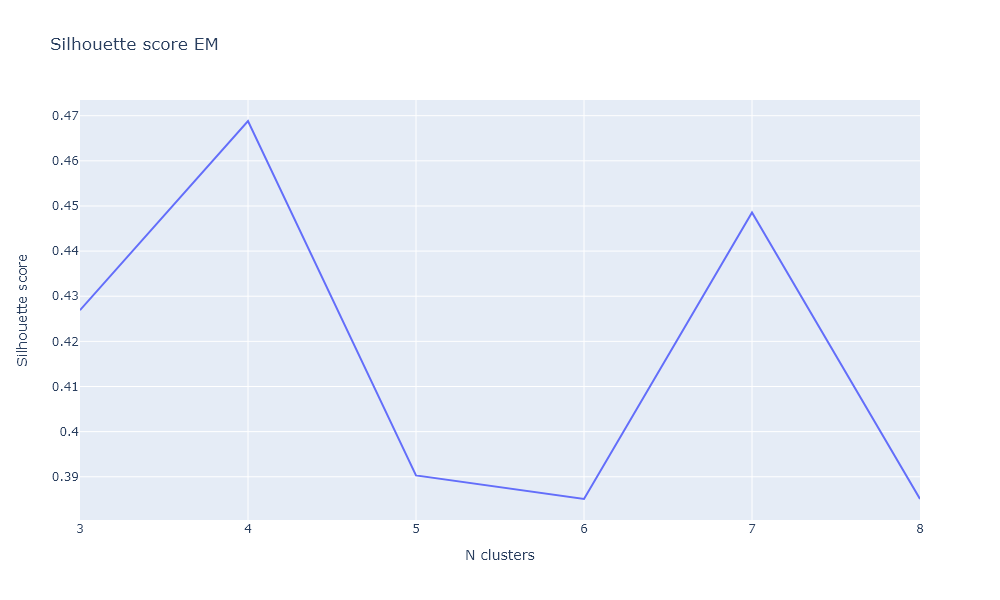

In [63]:
silh_scores_em = []
for n in n_clust_range:
    model = GaussianMixture(n_components=n, random_state=RANDOM_STATE)
    silh_scores_em.append(get_silhouet(rfm_table_processed, model))

fig = px.line(x=n_clust_range, y=silh_scores_em,
              labels={'y':'Silhouette score', 'x': 'N clusters'},
              title='Silhouette score EM',
              width=1000,
              height=600,
              )
fig.show(PX_MODE)

### AgglomerativeClustering
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта.


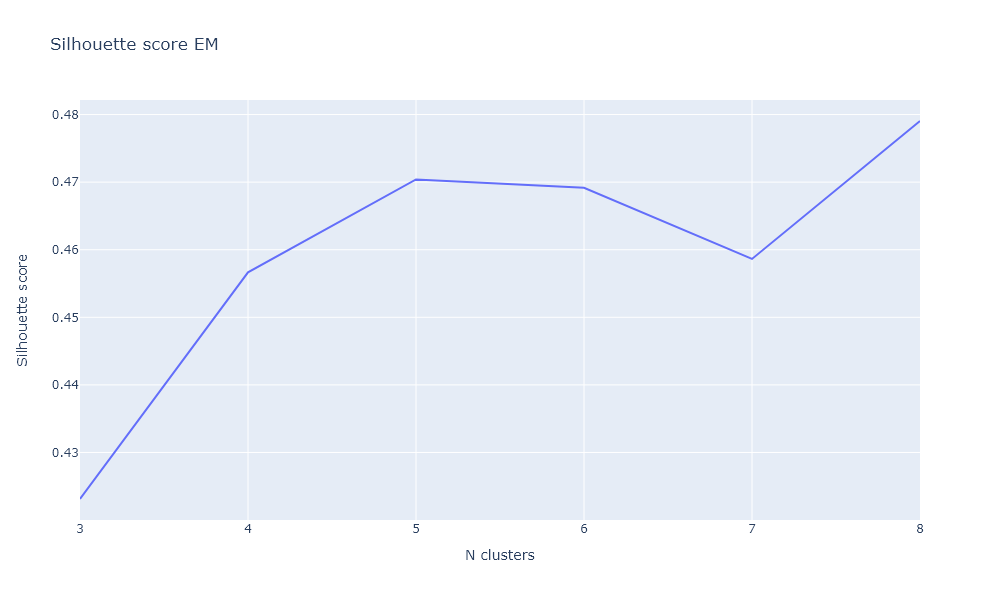

In [64]:
silh_scores_AG = []
for n in n_clust_range:
    model = AgglomerativeClustering(n_clusters=n)
    silh_scores_AG.append(get_silhouet(rfm_table_processed, model))

fig = px.line(x=n_clust_range, y=silh_scores_AG,
              labels={'y':'Silhouette score', 'x': 'N clusters'},
              title='Silhouette score EM',
              width=1000,
              height=600,
              )
fig.show(PX_MODE)

Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных и посмотрим на результаты кластеризации.

In [65]:
model = KMeans(n_clusters=7, random_state=RANDOM_STATE)
labels = model.fit_predict(rfm_table_processed)
np.unique(labels, return_counts=True) 

(array([0, 1, 2, 3, 4, 5, 6]),
 array([656, 914, 543, 397, 446, 683, 405], dtype=int64))

Визуализируем результаты кластеризации:

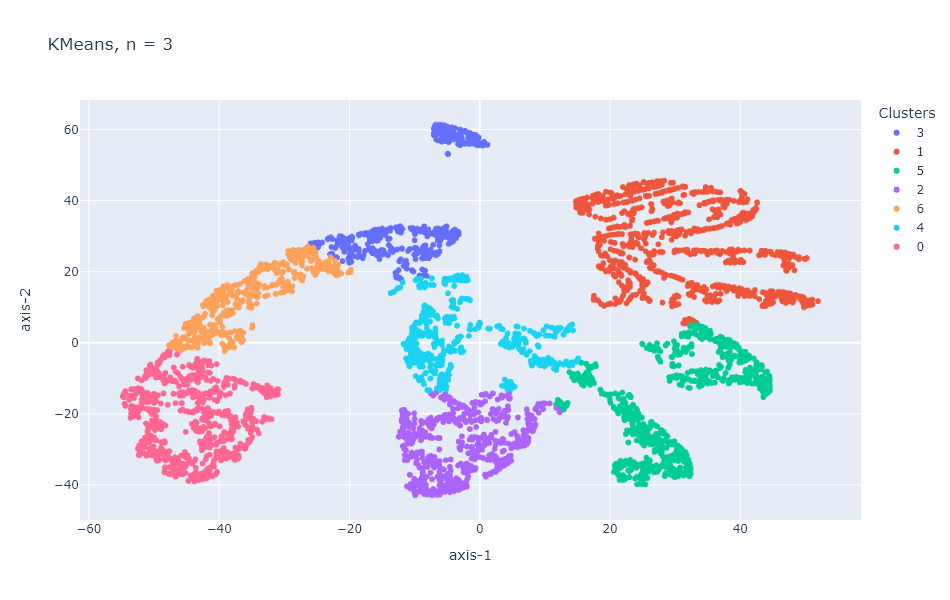

In [66]:
fig = px.scatter(
    rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    width=950,
    height=600,
    color=[str(label) for label in labels],
    labels={'color': 'Clusters'},
    title='KMeans, n = 3'
)

fig.update_layout(showlegend=True)
fig.show(PX_MODE);


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).
Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. 


In [67]:
rfm_table_cleaned['label'] = labels

rfm_grouped = rfm_table_cleaned.groupby(by='label').mean()
rfm_grouped

,Recency,Frequency,Monetary
label,,,
0,46.329268,1.000000,321.538796
1,32.400438,6.770241,2416.582451
2,40.022099,1.979742,613.663941
3,313.000000,1.012594,261.105315
4,195.800448,2.441704,670.317960
5,40.149341,3.450952,995.197350
6,181.439506,1.000000,273.465160


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.



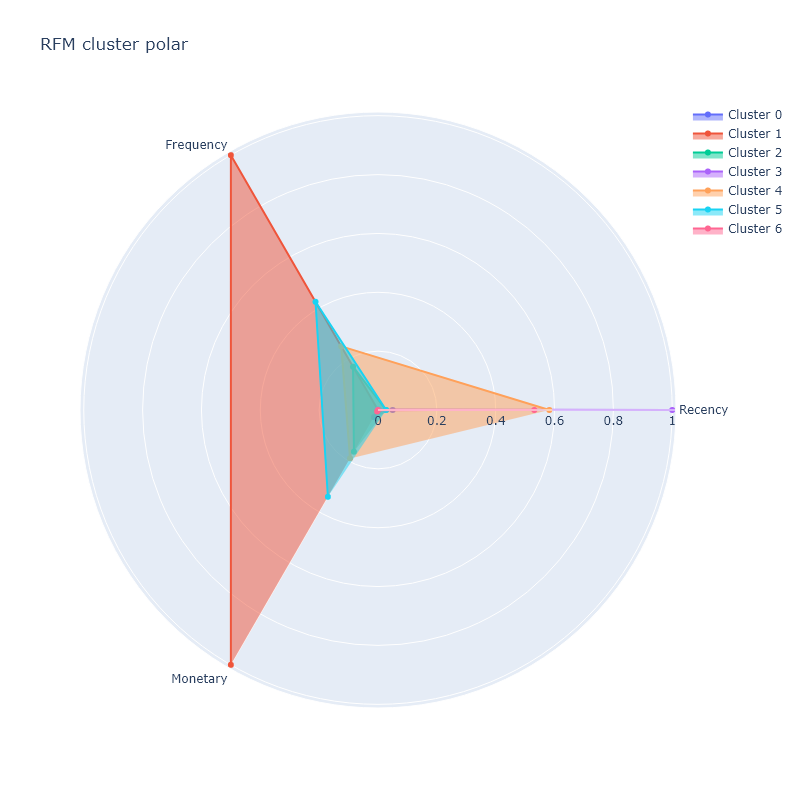

In [68]:
plot_cluster_profile(rfm_grouped, 7)

Видим:
* 1ой кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* 4ый кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* 2ой кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* 5ый кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* 0ой кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* 6ой кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* 3ий кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.


## 7. RFM-кластеризация клиентов: часть 3

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20. 

In [95]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned.drop('label', axis=1) #очищенная RFM-таблица
y = rfm_table_cleaned['label'] #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)
X_test.shape

(809, 3)

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче будут уступать в качесте.

Но возьмем ее как точку отсчета.

In [96]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train);
print(f'{"Train":-^70}\n{classification_report(y_train,model.predict(X_train))}')
print(f'{"Test":-^70}\n{classification_report(y_test,model.predict(X_test))}')

--------------------------------Train---------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       516
           1       0.94      0.94      0.94       731
           2       0.98      0.96      0.97       434
           3       0.98      0.99      0.98       326
           4       0.93      0.93      0.93       352
           5       0.92      0.91      0.91       550
           6       0.98      0.96      0.97       326

    accuracy                           0.95      3235
   macro avg       0.96      0.96      0.96      3235
weighted avg       0.95      0.95      0.95      3235

---------------------------------Test---------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       140
           1       0.94      0.95      0.94       183
           2       0.96      0.95      0.96       109
           3       0.97      0.97      0.97 

### Начнём со случайного леса. 


In [97]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500],
}
search = GridSearchCV(estimator=RandomForestClassifier(random_state=RANDOM_STATE),
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5,
                      verbose=2)
search.fit(X_train,y_train)
search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=500; total time=   0.8s
[CV] END ......criterion=gini, max_depth=5, n_e

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}

In [98]:
print(f'{"Random Forest Test":-^70}\n{classification_report(y_test,search.best_estimator_.predict(X_test), digits=3)}')

--------------------------Random Forest Test--------------------------
              precision    recall  f1-score   support

           0      0.993     1.000     0.996       140
           1      0.989     0.995     0.992       183
           2      1.000     0.982     0.991       109
           3      0.986     0.972     0.979        71
           4      0.968     0.979     0.974        94
           5      0.977     0.977     0.977       133
           6      0.975     0.975     0.975        79

    accuracy                          0.985       809
   macro avg      0.984     0.983     0.983       809
weighted avg      0.985     0.985     0.985       809



Оптимизация GridSearch происходит достаточно долго, для оптимизации гиперпарамтеров воспользуемся для сравнения Optuna

In [99]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 500, 1)
  max_depth = trial.suggest_int('max_depth', 5, 11, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

  # создаем модель
  model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 criterion=criterion,                                
                                 random_state=RANDOM_STATE)
  # оценим на кросс-валидации
  cv = StratifiedKFold(n_splits=5)
  score = cross_val_score(model, X, y, cv=cv, scoring="accuracy",n_jobs=-1).mean()

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForest", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=60, n_jobs=-1)

[I 2023-09-12 23:57:09,015] A new study created in memory with name: RandomForest
[I 2023-09-12 23:57:10,383] Trial 0 finished with value: 0.9745297335666818 and parameters: {'n_estimators': 365, 'max_depth': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.9745297335666818.
[I 2023-09-12 23:57:10,535] Trial 1 finished with value: 0.9809586459263974 and parameters: {'n_estimators': 422, 'max_depth': 6, 'criterion': 'gini'}. Best is trial 1 with value: 0.9809586459263974.
[I 2023-09-12 23:57:10,621] Trial 2 finished with value: 0.9863989890954485 and parameters: {'n_estimators': 220, 'max_depth': 9, 'criterion': 'gini'}. Best is trial 2 with value: 0.9863989890954485.
[I 2023-09-12 23:57:11,928] Trial 10 finished with value: 0.9856570267657172 and parameters: {'n_estimators': 168, 'max_depth': 9, 'criterion': 'gini'}. Best is trial 2 with value: 0.9863989890954485.
[I 2023-09-12 23:57:12,210] Trial 9 finished with value: 0.9861514643429732 and parameters: {'n_estimators': 118, 'ma

In [100]:
model_rf = RandomForestClassifier(**study.best_params,random_state=RANDOM_STATE )
model_rf.fit(X_train, y_train)
print(f'{"Random Forest Test":-^70}\n{classification_report(y_test, model_rf.predict(X_test), digits=4)}')

--------------------------Random Forest Test--------------------------
              precision    recall  f1-score   support

           0     0.9929    1.0000    0.9964       140
           1     0.9945    0.9891    0.9918       183
           2     1.0000    0.9817    0.9907       109
           3     0.9861    1.0000    0.9930        71
           4     0.9583    0.9787    0.9684        94
           5     0.9776    0.9850    0.9813       133
           6     1.0000    0.9747    0.9872        79

    accuracy                         0.9876       809
   macro avg     0.9871    0.9870    0.9870       809
weighted avg     0.9878    0.9876    0.9877       809



In [101]:
study.best_params

{'n_estimators': 389, 'max_depth': 10, 'criterion': 'entropy'}

Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Градиентный бустинг (GradientBoostingClassifier)


Для оптимизации гиперпарамтеров сразу воспользуемся Optuna

In [102]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 700, 1)
  max_depth = trial.suggest_int('max_depth', 3, 8, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)

  # создаем модель
  model = GradientBoostingClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     min_samples_leaf=min_samples_leaf,
                                     learning_rate=learning_rate,
                                     random_state=RANDOM_STATE)
  # оценим на кросс-валидации
  cv = StratifiedKFold(n_splits=5)
  score = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_2 = optuna.create_study(study_name="GradientBoosting", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_2.optimize(optuna_rf, n_trials=60, n_jobs=-1)

[I 2023-09-12 23:57:28,774] A new study created in memory with name: GradientBoosting
[I 2023-09-12 23:57:34,499] Trial 1 finished with value: 0.9898615819554761 and parameters: {'n_estimators': 361, 'max_depth': 5, 'min_samples_leaf': 6, 'learning_rate': 0.4252410002183172}. Best is trial 1 with value: 0.9898615819554761.
[I 2023-09-12 23:57:35,793] Trial 0 finished with value: 0.988872400837117 and parameters: {'n_estimators': 472, 'max_depth': 6, 'min_samples_leaf': 4, 'learning_rate': 0.44143467299585654}. Best is trial 1 with value: 0.9898615819554761.
[I 2023-09-12 23:57:39,790] Trial 7 finished with value: 0.9871418693167214 and parameters: {'n_estimators': 288, 'max_depth': 5, 'min_samples_leaf': 2, 'learning_rate': 0.29252720254041203}. Best is trial 1 with value: 0.9898615819554761.
[I 2023-09-12 23:57:46,350] Trial 16 finished with value: 0.9891208434811343 and parameters: {'n_estimators': 563, 'max_depth': 4, 'min_samples_leaf': 5, 'learning_rate': 0.28400951284800896}. Bes

In [103]:
# рассчитаем точность для тестовой выборки
model_boost = GradientBoostingClassifier(**study_2.best_params,random_state=RANDOM_STATE )
model_boost.fit(X_train, y_train)
print(f'{"Gradient boost Test":-^70}\n{classification_report(y_test, model_boost.predict(X_test), digits=4)}')

-------------------------Gradient boost Test--------------------------
              precision    recall  f1-score   support

           0     0.9929    1.0000    0.9964       140
           1     0.9838    0.9945    0.9891       183
           2     0.9908    0.9908    0.9908       109
           3     0.9859    0.9859    0.9859        71
           4     0.9583    0.9787    0.9684        94
           5     1.0000    0.9699    0.9847       133
           6     0.9872    0.9747    0.9809        79

    accuracy                         0.9864       809
   macro avg     0.9856    0.9849    0.9852       809
weighted avg     0.9865    0.9864    0.9864       809



In [104]:
optuna.visualization.plot_param_importances(study_2, target_name="accuracy")

Градиентный бустинг показал также хороший результат, но немного хуже чем Random Forest.

## Catboost

Попробуем, какой результат нам даст Catboost, на парметрах по умолчанию.

In [105]:
model_cat = CatBoostClassifier(random_state=RANDOM_STATE)
model_cat.fit(X_train, y_train)
y_pred = model_cat.predict(X_test)

Learning rate set to 0.084009
0:	learn: 1.5604678	total: 4.65ms	remaining: 4.65s
1:	learn: 1.3143983	total: 8.28ms	remaining: 4.13s
2:	learn: 1.1442055	total: 12.1ms	remaining: 4.03s
3:	learn: 1.0178599	total: 15.4ms	remaining: 3.84s
4:	learn: 0.9041689	total: 19.1ms	remaining: 3.8s
5:	learn: 0.8102019	total: 22.4ms	remaining: 3.72s
6:	learn: 0.7326201	total: 25.8ms	remaining: 3.66s
7:	learn: 0.6700242	total: 29.1ms	remaining: 3.61s
8:	learn: 0.6151720	total: 32.6ms	remaining: 3.59s
9:	learn: 0.5647415	total: 36ms	remaining: 3.56s
10:	learn: 0.5209106	total: 39.3ms	remaining: 3.53s
11:	learn: 0.4825554	total: 42.8ms	remaining: 3.53s
12:	learn: 0.4469078	total: 46.2ms	remaining: 3.5s
13:	learn: 0.4164876	total: 49.3ms	remaining: 3.47s
14:	learn: 0.3870362	total: 52.4ms	remaining: 3.44s
15:	learn: 0.3622116	total: 55.4ms	remaining: 3.4s
16:	learn: 0.3407605	total: 58.7ms	remaining: 3.39s
17:	learn: 0.3203094	total: 61.8ms	remaining: 3.37s
18:	learn: 0.3008074	total: 64.8ms	remaining: 3.3

In [106]:
print(f'{"Cat boost Test":-^70}\n{classification_report(y_test, y_pred, digits=4)}')

----------------------------Cat boost Test----------------------------
              precision    recall  f1-score   support

           0     0.9929    1.0000    0.9964       140
           1     0.9891    0.9945    0.9918       183
           2     1.0000    1.0000    1.0000       109
           3     0.9857    0.9718    0.9787        71
           4     0.9688    0.9894    0.9789        94
           5     1.0000    0.9774    0.9886       133
           6     0.9747    0.9747    0.9747        79

    accuracy                         0.9889       809
   macro avg     0.9873    0.9868    0.9870       809
weighted avg     0.9890    0.9889    0.9889       809



Самый лучший результат, за самое короткое время.

### Stacking

Ну и на последок объединим наши лучшие модели 

In [107]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('RF', RandomForestClassifier(**{'n_estimators': 102, 'max_depth': 10, 'criterion': 'entropy'},random_state=RANDOM_STATE )),
    ('CatBoost', model_cat)
    
]
# Создаем объект класса стекинг
model_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=2
)
model_stack.fit(X_train, y_train)
y_pred = model_stack.predict(X_test)
print(f'{"StackClassif Test":-^70}\n{classification_report(y_test, y_pred, digits=4)}')

--------------------------StackClassif Test---------------------------
              precision    recall  f1-score   support

           0     0.9929    1.0000    0.9964       140
           1     0.9945    0.9891    0.9918       183
           2     1.0000    1.0000    1.0000       109
           3     0.9859    0.9859    0.9859        71
           4     0.9688    0.9894    0.9789        94
           5     0.9924    0.9850    0.9887       133
           6     0.9872    0.9747    0.9809        79

    accuracy                         0.9901       809
   macro avg     0.9888    0.9891    0.9890       809
weighted avg     0.9902    0.9901    0.9901       809



Отлично, результат на тесте accuracy=0.990

Мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

В заключение, сегментация клиентов не ограничивается только RFM-анализом. Что ещё можно сделать?

- Выделить оптовиков в отдельный сегмент. В таком случае идея метода RFM расширяется путём добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе.
- Произвести кластерный анализ товаров на основе их описания и сформировать категории, по которым совершаются покупки.
- Рассчитать частоту покупки каждой категории товаров для каждого клиента. Эта информация может стать основой для построения модели кластеризации и сегментирования клиентов по их интересам.
- Наконец, воспользоваться информацией о сезонности покупок и добавить в модель информацию о частоте покупок клиентов в каждый из месяцев. Так можно определить, какие клиенты являются постоянными, то есть их покупки не зависят от сезона, а какие покупают товары только в преддверии праздников. Эта информация позволит экспериментировать с маркетинговой кампанией и повышать лояльность клиентов.